# Notebook pour l'évaluation des scores inter-annotateurs
Version : python 3.7

Dernière MAJ : 02/09/2021

Auteur : Lucas Terriel

## Tâches 

- Récupérations des métadonnées sur le fichier de test brut (nombre de phrases, tokens, et caractères);

- Nombre total d'annotations par annotateurs sur le texte en général et par labels;

- Tableau d'accord et de déssacord entre annotateurs sur les mentions annotées;

- Pourcentage d'alignement et de non-alignement;

- Calcul du Cohen Kappa pour des paires d'annotateurs, du Fleiss Kappa pour le groupe et interprétation du Kappa;

- Histogramme présentant le nombre de mention annotées par label pour chaque annoteurs et moyenne de label utilisé pour le groupe;

- Évaluation de l'alignement des classes entre les annotateurs.

In [1]:
from collections import Counter
from itertools import combinations
from os.path import basename, splitext
from os import walk
from math import trunc
import pprint
pp = pprint.PrettyPrinter(indent=2)

from cassis import *
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd 
import statistics

[nltk_data] Downloading package punkt to /home/lterriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Description du fichier de test brut

In [5]:
# Changer le chemin de fichier 
baseline_path = "../N4ACorpus/EAD_IAA/3_07102021/raw/doc_baseline_IAA_3.txt"
filename = basename(baseline_path)
filename_no_extension = splitext(filename)[0]

# Affichage des résultats
print(f"\t\t** Description du fichier : {filename} **\n")
with open(baseline_path, "r", encoding="UTF-8") as f:
    file = f.read()
    sentences = sent_tokenize(file)
    words = word_tokenize(file)
    chars = len(file)
    print(f"""
              - Nombres de phrases : {len(sentences)}
              - Nombres de tokens :  {len(words)}
              - Nombres de caractères : {chars}""")

		** Description du fichier : doc_baseline_IAA_3.txt **


              - Nombres de phrases : 47
              - Nombres de tokens :  1025
              - Nombres de caractères : 5927


### Traitements des fichiers XMI de chaque annotateurs (récupérés via INCEpTION) 

In [6]:
# changer le chemin vers le dossier contenant chacun des fichiers annotés
base_annots = "../N4ACorpus/EAD_IAA/3_07102021/annotators/"

for root, dirs, files in walk(base_annots):
    typesystem_file = files[0]
    xmi_files = files[1:]

# ouverture du typesystem nécéssaire pour interpréter le schéma du XMI
with open(base_annots + typesystem_file, 'rb') as f:
    typesystem = load_typesystem(f)

# vérification
for xmi in xmi_files:
    print(xmi)

pauline-charbonnier.xmi
lucas-terriel.xmi
gaetano-piraino.xmi
vincent-verdese.xmi


### Création des structures de données nécéssaires pour les calculs

In [7]:
Docs = {}
pairwise = {}
commune_mention = []


for xmi in xmi_files:
    annotations = {}
    labels = []
    person = os.path.splitext(xmi)[0]
    with open(base_annots + xmi, 'rb') as f:
        cas = load_cas_from_xmi(f, typesystem=typesystem)
        for ne in cas.select('de.tudarmstadt.ukp.dkpro.core.api.ner.type.NamedEntity'):
            annotations[ne.get_covered_text()] = ne.value
            commune_mention.append(ne.get_covered_text())
            labels.append(ne.value)
        
        pairwise[person] = labels
        Docs[person] = annotations
    

### Nombre total d'annotations par annotateurs sur le texte en général et par labels

In [8]:
labels_ann = []
dicts_coders = []
for coder, annotations in Docs.items():
    nombre_annotations = []
    print(f'* {coder}')
    for annotation, label in annotations.items():
        nombre_annotations.append(label)
    print(f"Nombre total d'annotations : {len(nombre_annotations)}")
    dict_coder = dict(Counter(nombre_annotations))
    pp.pprint(dict_coder)
    dicts_coders.append(dict_coder)
    print(f'==========================')

* pauline-charbonnier
Nombre total d'annotations : 134
{'EVENT': 1, 'LOCATION': 53, 'ORGANISATION': 24, 'PERSON': 38, 'TITLE': 18}
* lucas-terriel
Nombre total d'annotations : 132
{'EVENT': 1, 'LOCATION': 50, 'ORGANISATION': 27, 'PERSON': 40, 'TITLE': 14}
* gaetano-piraino
Nombre total d'annotations : 139
{'LOCATION': 49, 'ORGANISATION': 33, 'PERSON': 42, 'TITLE': 15}
* vincent-verdese
Nombre total d'annotations : 137
{'EVENT': 2, 'LOCATION': 52, 'ORGANISATION': 29, 'PERSON': 39, 'TITLE': 15}


### Initialisation de la dataframe

In [9]:
commune_mention = list(dict.fromkeys(commune_mention))

# création de la dataframe à partir des mentions communément annotées par les annotateurs  
data = [Docs]
df = pd.DataFrame(data, index =commune_mention) 

# initialisation des valeurs de la dataframe avec None
df['pauline-charbonnier'] = 'None'
df['lucas-terriel'] = 'None'
df['gaetano-piraino'] = 'None'
df['vincent-verdese'] = 'None'

### Récupération du nombre total des annotations et visualisation du label proposé par chaque annotateur pour chaque mentions admises

In [23]:
annotators = ['pauline-charbonnier', 'lucas-terriel', 'gaetano-piraino', 'vincent-verdese']

for ann in annotators:
    for mention,value in Docs[ann].items():
        df.loc[mention,ann] = value

total_annotations = len(df)

print(f'* Total des annotations : {total_annotations}')

df[0:10]

* Total des annotations : 172


pauline-charbonnier lucas-terriel gaetano-piraino  \
Lyon                             LOCATION      LOCATION        LOCATION   
Étienne Brocade                    PERSON        PERSON          PERSON   
homme de labeur                     TITLE         TITLE           TITLE   
bailliage de Berry           ORGANISATION  ORGANISATION    ORGANISATION   
Martin de Béthencourt              PERSON        PERSON          PERSON   
Rebreuve-sur-Canche              LOCATION      LOCATION        LOCATION   
Jean de Boffles                    PERSON        PERSON          PERSON   
Jean Le Moicte                     PERSON        PERSON          PERSON   
de Boffles                         PERSON        PERSON            None   
Pas-de-Calais                    LOCATION      LOCATION            None   

                      vincent-verdese  
Lyon                         LOCATION  
Étienne Brocade                PERSON  
homme de labeur                 TITLE  
bailliage de Berry       ORGANISATION  
Martin de Béthencourt          PERSON  
Rebreuve-sur-Canche          LOCATION  
Jean de Boffles                PERSON  
Jean Le Moicte                 PERSON  
de Boffles                       None  
Pas-de-Calais                LOCATION

### Tableau d'accord et de déssacord entre annotateurs sur les mentions annotées et pourcentage d'alignement et de non-alignement

#### Accord entre annotateurs

In [11]:
columns_to_compare = annotators

def check_all_equal(iterator):
    return len(set(iterator)) <= 1

df_agree = df[df[columns_to_compare].apply(lambda row: check_all_equal(row), axis=1)]
total_unanime = len(df_agree)

# alignement
print(f"* Total des annotations unanimes : {total_unanime} / {total_annotations} annotations soit {(total_unanime/total_annotations) * 100} % d'alignement")

# export du tableau
df_agree.to_csv(f'./out/agree_{filename_no_extension}.csv', encoding='utf-8')

# prévisualisation
df_agree[0:10]

* Total des annotations unanimes : 95 / 172 annotations soit 55.23255813953488 % d'alignement


pauline-charbonnier lucas-terriel  \
Lyon                                                LOCATION      LOCATION   
Étienne Brocade                                       PERSON        PERSON   
homme de labeur                                        TITLE         TITLE   
bailliage de Berry                              ORGANISATION  ORGANISATION   
Martin de Béthencourt                                 PERSON        PERSON   
Rebreuve-sur-Canche                                 LOCATION      LOCATION   
Jean de Boffles                                       PERSON        PERSON   
Jean Le Moicte                                        PERSON        PERSON   
arrondissement de Saint-Pol-sur-Ternoise        ORGANISATION  ORGANISATION   
canton d'Avesnes-le-Comte                       ORGANISATION  ORGANISATION   

                                         gaetano-piraino vincent-verdese  
Lyon                                            LOCATION        LOCATION  
Étienne Brocade                                   PERSON          PERSON  
homme de labeur                                    TITLE           TITLE  
bailliage de Berry                          ORGANISATION    ORGANISATION  
Martin de Béthencourt                             PERSON          PERSON  
Rebreuve-sur-Canche                             LOCATION        LOCATION  
Jean de Boffles                                   PERSON          PERSON  
Jean Le Moicte                                    PERSON          PERSON  
arrondissement de Saint-Pol-sur-Ternoise    ORGANISATION    ORGANISATION  
canton d'Avesnes-le-Comte                   ORGANISATION    ORGANISATION

#### Désaccord entre annotateurs

In [12]:
columns_to_compare = annotators
def check_all_not_equal(iterator):
    return len(set(iterator)) > 1

df_disagree = df[df[columns_to_compare].apply(lambda row: check_all_not_equal(row), axis=1)]
total_desaccord = len(df_disagree)

# non-alignement
print(f"* Total des annotations en désaccord : {total_desaccord} / {total_annotations} annotations soit {(total_desaccord/total_annotations) * 100} % de non-alignement")

# export du tableau
df_disagree.to_csv(f'./out/disagree_{filename_no_extension}.csv', encoding='utf-8')

# prévisualisation
df_disagree[20:40]

* Total des annotations en désaccord : 77 / 172 annotations soit 44.76744186046512 % de non-alignement


pauline-charbonnier lucas-terriel  \
prieuré de Coincy                            ORGANISATION      LOCATION   
seigneur de Joncourt                                TITLE         TITLE   
Boulogne-sur-Mer                                 LOCATION          None   
Ateliers A Couachi                           ORGANISATION          None   
Arcachon                                         LOCATION      LOCATION   
artistes                                            TITLE          None   
Louis Herduin                                      PERSON          None   
Gabriel Bardon                                     PERSON        PERSON   
guerre 14-18                                        EVENT         EVENT   
chefs d'État                                        TITLE          None   
Chefs d'État                                        TITLE          None   
Francophonie                                 ORGANISATION          None   
France                                           LOCATION      LOCATION   
Meythet                                          LOCATION          None   
Nemours                                          LOCATION      LOCATION   
Clinique Korian Roger Salengro               ORGANISATION  ORGANISATION   
Saint-Denis                                      LOCATION      LOCATION   
Clinique du Grand Stade                      ORGANISATION  ORGANISATION   
Maison de santé médicale Joseph Sauvy        ORGANISATION  ORGANISATION   
la Charité-sur-Loire                                 None      LOCATION   

                                      gaetano-piraino vincent-verdese  
prieuré de Coincy                        ORGANISATION    ORGANISATION  
seigneur de Joncourt                           PERSON           TITLE  
Boulogne-sur-Mer                                 None            None  
Ateliers A Couachi                               None    ORGANISATION  
Arcachon                                         None        LOCATION  
artistes                                        TITLE            None  
Louis Herduin                                  PERSON          PERSON  
Gabriel Bardon                               LOCATION          PERSON  
guerre 14-18                                     None           EVENT  
chefs d'État                                    TITLE            None  
Chefs d'État                                    TITLE            None  
Francophonie                                     None            None  
France                                           None            None  
Meythet                                      LOCATION        LOCATION  
Nemours                                          None        LOCATION  
Clinique Korian Roger Salengro                   None    ORGANISATION  
Saint-Denis                                      None        LOCATION  
Clinique du Grand Stade                          None    ORGANISATION  
Maison de santé médicale Joseph Sauvy            None    ORGANISATION  
la Charité-sur-Loire                             None            None

### Calcul du Cohen Kappa pour des paires d'annotateurs, du Fleiss Kappa pour le groupe et interprétation du Kappa

- code source adapté : [De Brujn, L., *Inter-Annotator Agreement (IAA)*, towards data science, 2020](https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3)
- pour l'interprétation du Kappa : [Anthony J. Viera, MD, Garrett, J.M., *Understanding Interobserver Agreement:The Kappa Statistic*, 2005](http://www1.cs.columbia.edu/~julia/courses/CS6998/Interrater_agreement.Kappa_statistic.pdf)

In [13]:
df_n = df.apply(pd.Series.value_counts, 1).fillna(0).astype(int)
matrix = df_n.values

def cohen_kappa_function(ann1, ann2):
    """Computes Cohen kappa for pair-wise annotators.
    :param ann1: annotations provided by first annotator
    :type ann1: list
    :param ann2: annotations provided by second annotator
    :type ann2: list
    :rtype: float
    :return: Cohen kappa statistic
    """
    count = 0
    for an1, an2 in zip(ann1, ann2):
        if an1 == an2:
            count += 1
    A = count / len(ann1)  # observed agreement A (Po)

    uniq = set(ann1 + ann2)
    E = 0  # expected agreement E (Pe)
    for item in uniq:
        cnt1 = ann1.count(item)
        cnt2 = ann2.count(item)
        count = (cnt1 / len(ann1)) * (cnt2 / len(ann2))
        E += count

    return round((A - E) / (1 - E), 4)


def fleiss_kappa_function(M):
    """Computes Fleiss' kappa for group of annotators.
    :param M: a matrix of shape (:attr:'N', :attr:'k') with 'N' = number of subjects and 'k' = the number of categories.
        'M[i, j]' represent the number of raters who assigned the 'i'th subject to the 'j'th category.
    :type: numpy matrix
    :rtype: float
    :return: Fleiss' kappa score
    """
    N, k = M.shape  # N is # of items, k is # of categories
    n_annotators = float(np.sum(M[0, :]))  # # of annotators
    tot_annotations = N * n_annotators  # the total # of annotations
    category_sum = np.sum(M, axis=0)  # the sum of each category over all items

    # chance agreement
    p = category_sum / tot_annotations  # the distribution of each category over all annotations
    PbarE = np.sum(p * p)  # average chance agreement over all categories

    # observed agreement
    P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    Pbar = np.sum(P) / N  # add all observed agreement chances per item and divide by amount of items

    return round((Pbar - PbarE) / (1 - PbarE), 4)

def interpret_kappa(score):
    if score < 0:
        return "Less chance agreement\n"
    elif 0.01 <= score <= 0.20:
        return "Slight agreement\n"
    elif 0.21 <= score <= 0.40:
        return "Fair agreement\n"
    elif 0.41 <= score <= 0.60:
        return "Moderate agreement\n"
    elif 0.61 <= score <= 0.80:
        return "Substantial agreement\n"
    elif 0.81 <= score <= 0.99:
        return "Almost perfect agreement\n"

pairs = list(combinations(annotators, 2))

print("\t\t -- Results Cohen Kappa --\n")
for coder_1, coder_2 in pairs:
    cohen_function = cohen_kappa_function(pairwise[coder_1], pairwise[coder_2])
    print(f"* {coder_1} <> {coder_2} : {cohen_function}")
    print(f"\t|=>{interpret_kappa(cohen_function)}")
    
print("\n")

fleiss_function = fleiss_kappa_function(matrix)

print(f"-- Fleiss'Kappa score for group NER4Archives: {fleiss_function}")
print(f"\t|=>{interpret_kappa(fleiss_function)}")

		 -- Results Cohen Kappa --

* pauline-charbonnier <> lucas-terriel : 0.3952
	|=>Fair agreement

* pauline-charbonnier <> gaetano-piraino : 0.2251
	|=>Fair agreement

* pauline-charbonnier <> vincent-verdese : 0.5182
	|=>Moderate agreement

* lucas-terriel <> gaetano-piraino : 0.3563
	|=>Fair agreement

* lucas-terriel <> vincent-verdese : 0.4721
	|=>Moderate agreement

* gaetano-piraino <> vincent-verdese : 0.3726
	|=>Fair agreement



-- Fleiss'Kappa score for group NER4Archives: 0.6863
	|=>Substantial agreement



### Histogramme présentant le nombre de mention annotées par label pour chaque annoteurs et moyenne de label utilisé pour le groupe

In [14]:
# création de la structure de données pour la mise en place de l'histogramme
dict_to_histogram = {
    k: [0 if d.get(k) == None else d.get(k) for d in dicts_coders]
    for k in set().union(*dicts_coders)
}

for i in dict_to_histogram.items():
    print(i)

('TITLE', [18, 14, 15, 15])
('EVENT', [1, 1, 0, 2])
('PERSON', [38, 40, 42, 39])
('ORGANISATION', [24, 27, 33, 29])
('LOCATION', [53, 50, 49, 52])


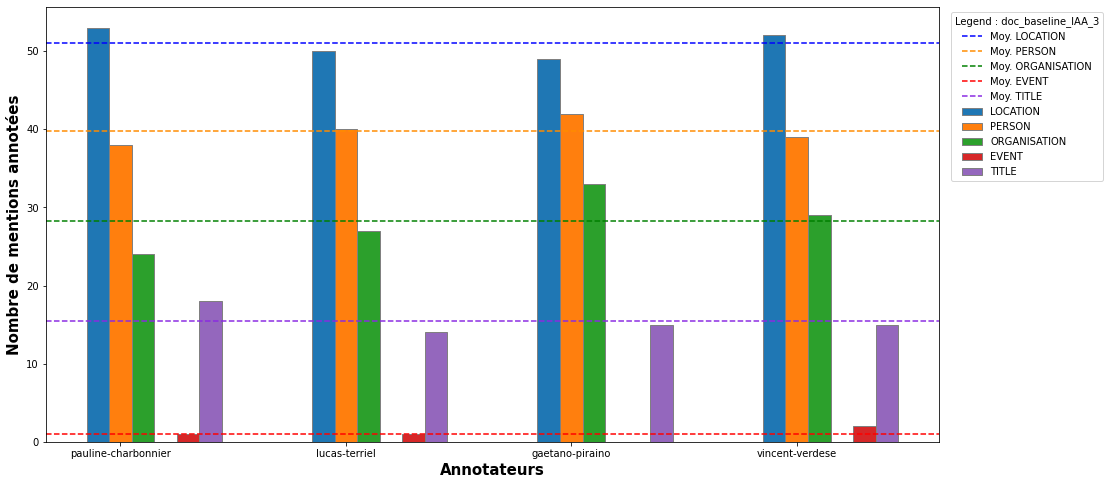

In [22]:
# A adapter selon les types de labels, le nombre d'annotateurs 
 
# réglages généraux de la figure
barWidth = 0.10
fig = plt.subplots(figsize =(16, 8))

# réglage de la hauteur des barres
LOCATION = dict_to_histogram['LOCATION']
PERSON = dict_to_histogram['PERSON']
ORGANISATION = dict_to_histogram['ORGANISATION']
#INSTALLATION = dict_to_histogram['INSTALLATION']
EVENT = dict_to_histogram['EVENT']
#UNKNOWN = dict_to_histogram['UNKNOWN']
#LEGAL = dict_to_histogram['LEGAL']
TITLE = dict_to_histogram['TITLE']
#INSTITUTION = dict_to_histogram['INSTITUTION']

# mise en place de la position des barres sur l'axe des abscisses (X)
br1 = np.arange(len(LOCATION))
br2 = [x + barWidth for x in br1]
br3 = [x1 + barWidth for x1 in br2]
br4 = [x2 + barWidth for x2 in br3]
br5 = [x3 + barWidth for x3 in br4]
br6 = [x4 + barWidth for x4 in br5]
br7 = [x5 + barWidth for x5 in br6]
br8 = [x6 + barWidth for x6 in br7]
br9 = [x6 + barWidth for x6 in br8]

# ajouter les barres et les lignes moyenne (couleurs, style de fonts...)
plt.bar(br1, 
        LOCATION, 
        width = barWidth,
        edgecolor ='grey', 
        label ='LOCATION')
plt.axhline(y = statistics.mean(LOCATION), color = 'b', linestyle = '--', label = "Moy. LOCATION")

plt.bar(br2, 
        PERSON, 
        width = barWidth,
        edgecolor ='grey', 
        label ='PERSON')
plt.axhline(y = statistics.mean(PERSON), color = 'darkorange', linestyle = '--', label = "Moy. PERSON")

plt.bar(br3, 
        ORGANISATION, 
        width = barWidth,
        edgecolor ='grey', 
        label ='ORGANISATION')
plt.axhline(y = statistics.mean(ORGANISATION), color = 'g', linestyle = '--', label = "Moy. ORGANISATION")

"""
plt.bar(br4, 
        INSTALLATION, 
        width = barWidth,
        edgecolor ='grey', 
        label ='INSTALLATION')
plt.axhline(y = statistics.mean(INSTALLATION), color = 'r', linestyle = '--', label = "Moy. INSTALLATION")
"""

plt.bar(br5, 
        EVENT, 
        width = barWidth,
        edgecolor ='grey', 
        label ='EVENT')
plt.axhline(y = statistics.mean(EVENT), color = 'red', linestyle = '--', label = "Moy. EVENT")

"""
plt.bar(br6, 
        UNKNOWN, 
        width = barWidth,
        edgecolor ='grey', 
        label ='UNKNOWN')
plt.axhline(y = statistics.mean(UNKNOWN), color = 'tab:brown', linestyle = '--', label = "Moy. UNKNOWN")
"""
"""
plt.bar(br7, 
        LEGAL,  
        width = barWidth,
        edgecolor ='grey', 
        label ='LEGAL')
#plt.axhline(y = statistics.mean(LEGAL), color = 'tab:pink', linestyle = '--', label = "Moy. LEGAL")
"""
plt.bar(br6, 
        TITLE,  
        width = barWidth,
        edgecolor ='grey', 
        label ='TITLE')
plt.axhline(y = statistics.mean(TITLE), color = 'blueviolet', linestyle = '--', label = "Moy. TITLE")

"""
plt.bar(br7, 
        INSTITUTION,  
        width = barWidth,
        edgecolor ='grey', 
        label ='INSTITUTION')
#plt.axhline(y = statistics.mean(INSTITUTION), color = 'r', linestyle = '--', label = "Moy. INSTITUTION")
"""

plt.xlabel('Annotateurs', fontweight ='bold', fontsize = 15)
plt.ylabel('Nombre de mentions annotées', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(annotators))],
        annotators)

# export de l'histogramme
plt.savefig(f'./out/labels_per_annotators_{filename_no_extension}.png', dpi=400)
# prévisualisation
plt.legend(title=f'Legend : {filename_no_extension}', bbox_to_anchor=(1.19, 1), loc='upper right')
plt.show()

### Évaluation de l'alignement des classes entre les annotateurs

In [17]:
labels = ['LOCATION', 'PERSON', 'ORGANISATION', 'EVENT', 'TITLE']

# Récupérer le total de mentions annotés avec un type de classe

def count_total_annotations_label(dataframe, labels):
    """Nombre total de lignes (mentions annotées) portant au moins une classe"""
    pairs = []
    for label in labels:
        total = dataframe.astype(object).eq(label).any(1).sum()
        pairs.append((label, total))
    return pairs

totals_annotations_per_labels = count_total_annotations_label(df, labels)

# Récupérer le nombre de mention portant la même classe selon les annotateurs

def total_agree_disagree_per_label(dataframe, pairs_totals_labels):
    """
    Pour chaque classe :
    1. Nombre de mentions où les annotateurs ont mis la même classe;
    2. Nombre de mentions où les annotateurs n'ont pas été d'accord sur la classe;
    3. Conversion en pourcentage;
    4. Récupération de la classe, du nombre total de mention portant au moins la classe, pourcentage de mention annotées avec la même classe,
    et pourcentage de mentions annotées portant la classe pour au moins un annotateur. 
    """
    new_pairs = []
    for t in pairs_totals_labels:
        # t[0] : label
        # t[1] : total_rows_with_label
        agree_res = df[df.nunique(1).eq(1)].eq(t[0]).any(1).sum()
        disagree_res = t[1] - agree_res
        agree_percent = (agree_res / t[1]) * 100
        disagree_percent = (disagree_res / t[1]) * 100
        new_pairs.append((t[0], t[1], agree_percent, disagree_percent))
    return new_pairs

to_pie = total_agree_disagree_per_label(df, totals_annotations_per_labels)

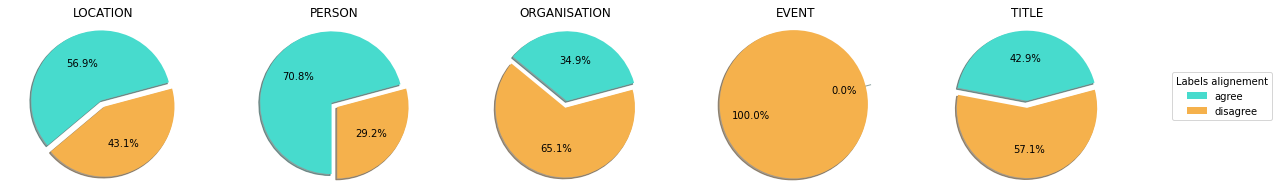

In [18]:
def plot_pies(tasks_to_pie):
    """Création d'un graphique circulaire par classe selon un rapport d'accord et de désaccord par annotateurs
    """
    my_labels = 'agree','disagree'
    my_colors = ['#47DBCD','#F5B14C']
    my_explode = (0, 0.1)
    counter = 0
    fig, axes = plt.subplots(1, len(tasks_to_pie),figsize=(20,3))
    for t in tasks_to_pie:
        tasks = [t[2], t[3]]
        axes[counter].pie(tasks, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
        axes[counter].set_title(t[0])
        axes[counter].axis('equal')
        counter +=1
    fig.set_facecolor("white")
    fig.legend(labels=my_labels, loc="center right", borderaxespad=0.1, title="Labels alignement")
    plt.savefig(f'./out/pie_alignement_labels_{filename_no_extension}.png', dpi=400)
    return plt.show()

plot_pies(to_pie)
